In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: nicer defaults
sns.set(style="whitegrid", context="talk")

df = pd.read_csv('results.csv')
org_map = {'hs': 'H.sapiens', 'bt': 'B.taurus', 'mm': 'M.musculus', 'dm': 'D.melanogaster'}
model_map = {'T': 'Transformer (org)', 'Tall': 'Transformer (all)', 'CNN': 'CNN 2D', 'base': 'Baseline'}
df['model'] = df['model'].map(model_map.get)
df['organism'] = df['organism'].map(org_map.get)

#signal = 'PAS'
signal = 'TIS'
motif = 'AATAAA' if signal == 'PAS' else 'ATG'
df = df.query(f'signal == "{signal}"')

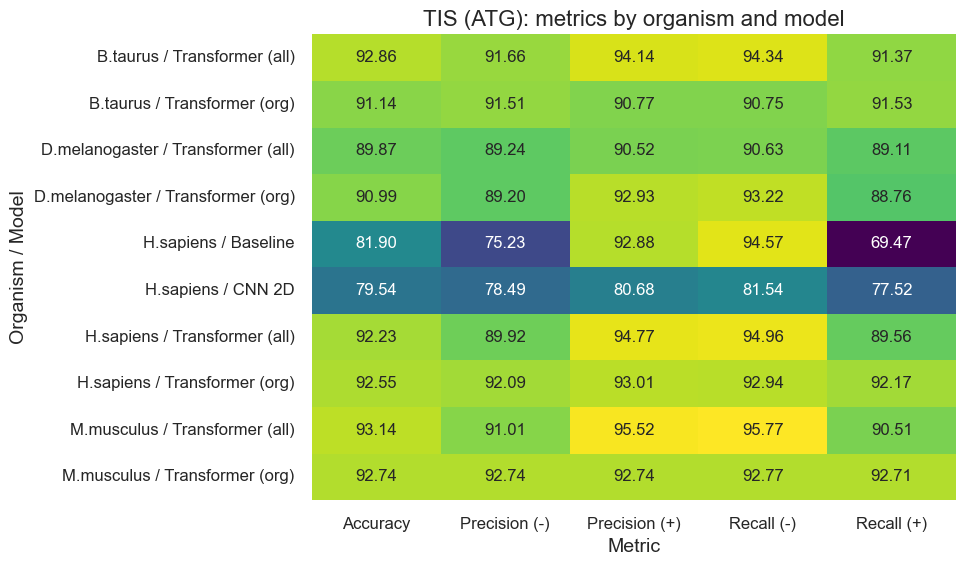

In [22]:
# Keep only the columns we need
test_cols = [
    "results.test.accuracy",
    "results.test.precision.neg",
    "results.test.precision.pos",
    "results.test.recall.neg",
    "results.test.recall.pos",
]

# Aggregate over `signal` if there are multiple rows per model/organism
df_test = (
    df.groupby(["organism", "model"], as_index=False)[test_cols]
      .mean()
)

# Create a label combining organism and model (e.g., hs_T, hs_Tall)
df_test["org_model"] = df_test["organism"] + " / " + df_test["model"]#.map(model_map.get)

# Reshape to wide form with org_model as rows, metrics as columns
heatmap_data = df_test.set_index("org_model")[test_cols]

# Optionally rename columns for nicer plotting
heatmap_data.columns = [
    "Accuracy",
    "Precision (-)",
    "Precision (+)",
    "Recall (-)",
    "Recall (+)",
]

fig = plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data*100,
    annot=True,
    annot_kws={'size': 12},
    fmt=".2f",
    cmap="viridis",
    cbar=False,
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f"{signal} ({motif}): metrics by organism and model", fontsize=16)
plt.ylabel("Organism / Model", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.tight_layout()
plt.show()

fig.savefig(f'heatmap_{signal}_{motif}.png', format='png', dpi=300)

/tmp/ipykernel_31664/1241020545.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("metric")["value"]
/tmp/ipykernel_31664/1241020545.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("metric")["value"]
/tmp/ipykernel_31664/1241020545.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("metric")["value"]
/tmp/ipykernel_31664/1241020545.py:66: FutureWarning: The default o

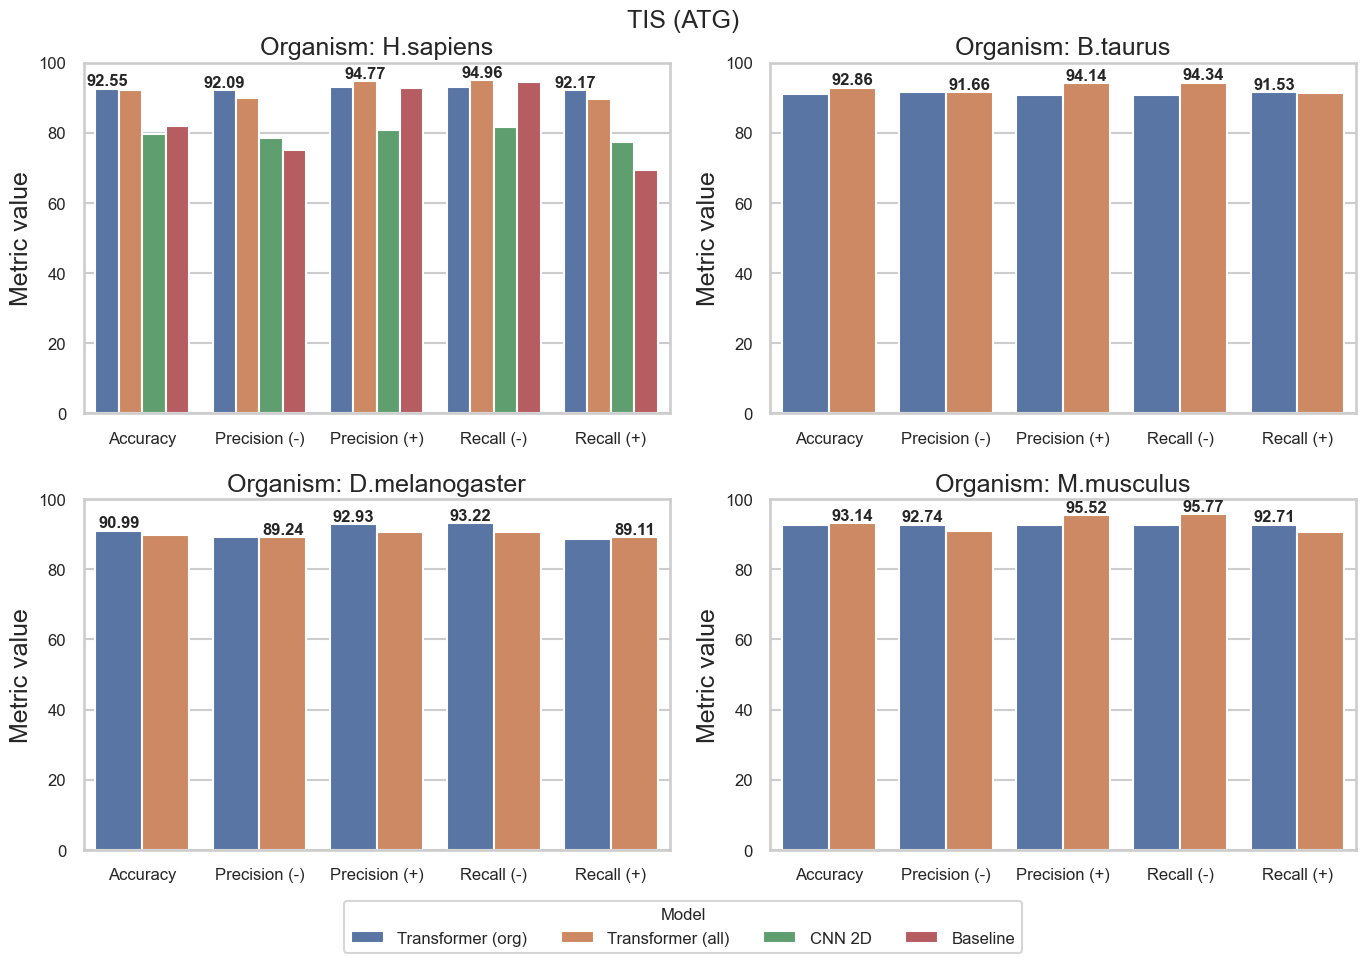

In [23]:
import numpy as np

metric_order = ["Accuracy", "Precision (-)", "Precision (+)", "Recall (-)", "Recall (+)"]
organisms = ["H.sapiens", "B.taurus", "D.melanogaster", "M.musculus"]  # adjust if needed

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

first_handles, first_labels = None, None

metric_rename = {
    "results.test.accuracy": "Accuracy",
    "results.test.precision.neg": "Precision (-)",
    "results.test.precision.pos": "Precision (+)",
    "results.test.recall.neg": "Recall (-)",
    "results.test.recall.pos": "Recall (+)",
}

df_test_long = df_test.melt(
    id_vars=["organism", "model"],
    value_vars=list(metric_rename.keys()),
    var_name="metric_raw",
    value_name="value",
)

df_test_long["metric"] = df_test_long["metric_raw"].map(metric_rename)
df_test_long['value'] = df_test_long['value']*100

for i, (ax, org) in enumerate(zip(axes, organisms)):
    subset = df_test_long[df_test_long["organism"] == org].copy()

    model_order = ['Transformer (org)', 'Transformer (all)'] + (['CNN 2D', 'Baseline'] if i == 0 else [])
    # Explicitly set categorical order so seaborn draws bars in a known order
    subset["metric"] = pd.Categorical(subset["metric"], categories=metric_order, ordered=True)
    subset["model"]  = pd.Categorical(subset["model"],  categories=model_order,  ordered=True)

    barplot = sns.barplot(
        data=subset,
        x="metric",
        y="value",
        hue="model",
        order=metric_order,
        hue_order=model_order,
        ax=ax
    )

    # Capture legend from first subplot only
    if i == 0:
        first_handles, first_labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

    ax.set_title(f"Organism: {org}")
    ax.set_ylim(0, 100.0)
    ax.set_xlabel("")
    ax.set_ylabel("Metric value")
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    # ---- Annotate tallest bar per metric ----
    patches = ax.patches
    n_metrics = len(metric_order)
    n_models  = len(model_order)

    # Precompute the max value per metric from the data
    metric_max = (
        subset.groupby("metric")["value"]
              .max()
              .to_dict()
    )

    for j, p in enumerate(patches[:n_metrics*n_models]):
        # Map patch index -> (metric, model) via known order
        metric_idx = j % n_metrics
        model_idx  = j //  n_metrics

        metric = metric_order[metric_idx]
        model  = model_order[model_idx]

        bar_height = p.get_height()
        max_for_metric = metric_max[metric]

        # Annotate only if this bar is the tallest for this metric
        if np.isclose(bar_height, max_for_metric):
            x = p.get_x() + p.get_width() / 2
            y = bar_height
            ax.text(
                x,
                y + 0.005,
                f"{bar_height:.2f}",
                ha="center",
                weight='bold',
                va="bottom",
                fontsize=12
            )        
    
fig.legend(
    first_handles,
    first_labels,
    title="Model",
    loc="lower center",
    ncol=4,
    fontsize=12,
    title_fontsize=12
)
fig.suptitle(f'{signal} ({motif})', fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for legend
plt.show()

fig.savefig(f'bar_{signal}_{motif}.png', format='png', dpi=300)

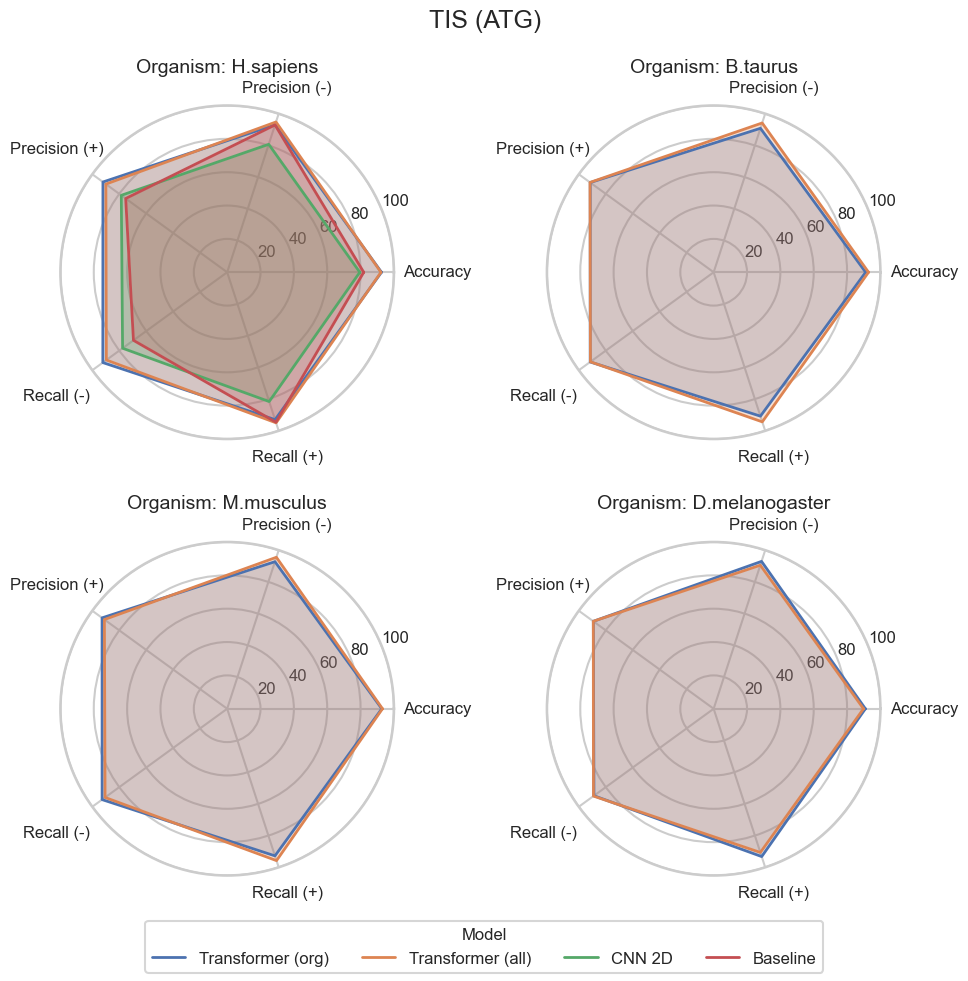

In [13]:
# We can reuse df_test: one row per (organism, model)
# Define metrics for radar
radar_metrics = [
    "results.test.accuracy",
    "results.test.precision.pos",
    "results.test.precision.neg",
    "results.test.recall.pos",
    "results.test.recall.neg",
]
radar_metric_labels = ["Accuracy", "Precision (-)", "Precision (+)", "Recall (-)", "Recall (+)"]

# Helper to extract metric values for one organism+model
def get_metric_values(df_test, organism, model, metrics):
    row = df_test[(df_test["organism"] == organism) & (df_test["model"] == model)]
    if row.empty:
        return None
    return row[metrics].iloc[0].values.astype(float)*100

def plot_radar_for_organism(ax, df_test, organism, models):
    # Prepare angle positions
    N = len(radar_metrics)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    for model in models:
        values = get_metric_values(df_test, organism, model, radar_metrics)
        if values is None:
            continue
        values = values.tolist()
        values += values[:1]  # close the loop

        ax.plot(angles, values, linewidth=2, label=model)
        ax.fill(angles, values, alpha=0.25)

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_metric_labels)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.set_ylim(0, 100.0)  # metrics assumed in [0,1]
    ax.set_title(f"Organism: {organism}", fontsize=14)
    
    for i, (label, angle) in enumerate(zip(ax.get_xticklabels(), angles)):
        label.set_horizontalalignment("center")
        label.set_verticalalignment("center")

        # Move each label farther away from the plot
        if i in [0, 2, 3]:
            label.set_position((label.get_position()[0], label.get_position()[1] - 0.1))    

# Call the radar plot function for each organism
fig, axs = plt.subplots(2, 2, figsize=(10, 10), subplot_kw=dict(polar=True))
axs = axs.flatten()
for ax, org in zip(axs, ["H.sapiens", "B.taurus", "M.musculus", "D.melanogaster"]):
    models = ["Transformer (org)", "Transformer (all)"]
    plot_radar_for_organism(ax, df_test, org, models=models + (['CNN 2D', 'Baseline'] if org == 'H.sapiens' else []))
    if org == 'H.sapiens':
        first_handles, first_labels = ax.get_legend_handles_labels()
    
fig.legend(
    first_handles,
    first_labels,
    title="Model",
    loc="lower center",
    ncol=4,
    fontsize=12,
    title_fontsize=12
)

fig.suptitle(f'{signal} ({motif})', fontsize=18, y=0.97)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for legend
plt.show()

fig.savefig(f'radar_{signal}_{motif}.png', format='png', dpi=300)